In [149]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [150]:
#read in data
titanic_train = pd.read_csv('C:/Users/juphillips/Datasets/titanic_train.csv')
titanic_test = pd.read_csv('C:/Users/juphillips/Datasets/titanic_test.csv')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
#initial exploration
print(titanic_train.shape)
print(titanic_train.columns)
print(titanic_train.dtypes)
print(titanic_train.describe())
print('Survival Rate:', titanic_train.Survived.mean())

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000   

In [152]:
#null analysis
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [153]:
#beginning with the fewest nulls 'Embarked'
print(titanic_train.Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [154]:
#impute nulls with mode for simplicity
titanic_train.Embarked.fillna('S', inplace = True)
titanic_train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [155]:
#age nulls next
#Instead of using only the mean, are there correlating features that can help us?
train_corr = titanic_train.corr()
train_corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


In [156]:
#Pclass has the strongest correlation with Age
print('Mean age only:', titanic_train.Age.mean())
titanic_train.groupby('Pclass')['Age'].median()

Mean age only: 29.69911764705882


Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [157]:
#impute with median age by Pclass
titanic_train['Age'] = titanic_train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
#change Pclass to categorical variable
titanic_train['Pclass'] = titanic_train['Pclass'].astype('category')

In [158]:
#The cabin feature majority is null, but can we extract any value from this column?
#use the cabin letter from each value and fill nulls with 'U' for 'Unknown'
titanic_train['Cabin_Letter'] = titanic_train['Cabin'].str[0].fillna('U')
titanic_train['Cabin_Letter'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [159]:
#Other new features could include family size and Title
titanic_train['Family_Size'] = titanic_train['Parch'] + titanic_train['SibSp'] + 1
titanic_train['Title'] = titanic_train.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
titanic_train['Title'] = titanic_train.Title.replace(['Master', 'Dr', 'Rev', 'Col', 'Major', 
                                                      'Ms', 'Mlle', 'Countess', 'Lady', 'Dona', 
                                                      'Sir', 'Jonkheer', 'Don', 'Capt', 'Mme'], 'Other')
titanic_train.Title.value_counts()

Mr       517
Miss     182
Mrs      125
Other     67
Name: Title, dtype: int64

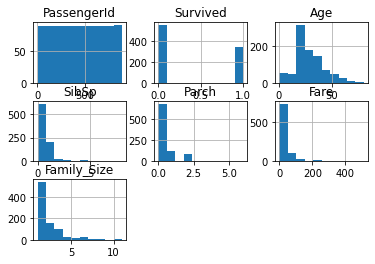

In [160]:
#Preprocessing numerical features
#feature histograms
titanic_train.hist()
plt.show()

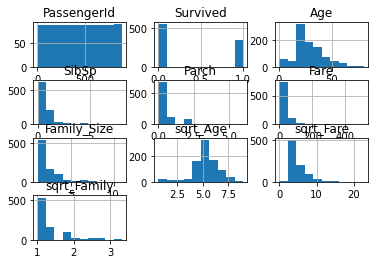

In [161]:
#Square root transform to more closely approximate a normal distribution
titanic_train['sqrt_Age'] = np.sqrt(titanic_train['Age'])
titanic_train['sqrt_Fare'] = np.sqrt(titanic_train['Fare'])
titanic_train['sqrt_Family'] = np.sqrt(titanic_train['Family_Size']+0.01)
titanic_train.hist()
plt.show()

In [162]:
#to remain consistent we apply the same preprocessing steps to the test set
titanic_test.Embarked.fillna('S', inplace = True)
titanic_test['Age'] = titanic_train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
titanic_test['Cabin_Letter'] = titanic_test['Cabin'].str[0].fillna('U')
titanic_test['Family_Size'] = titanic_test['Parch'] + titanic_test['SibSp'] + 1
titanic_test['Title'] = titanic_test.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
titanic_test['Title'] = titanic_test.Title.replace(['Master', 'Dr', 'Rev', 'Col', 'Major', 
                                                      'Ms', 'Mlle', 'Countess', 'Lady', 'Dona', 
                                                      'Sir', 'Jonkheer', 'Don', 'Capt', 'Mme'], 'Other')

titanic_test['sqrt_Age'] = np.sqrt(titanic_test['Age'])
titanic_test['Fare'] = titanic_train.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
titanic_test['sqrt_Fare'] = np.sqrt(titanic_test['Fare'])
titanic_test['sqrt_Family'] = np.sqrt(titanic_test['Family_Size']+0.01)
titanic_test['Pclass'] = titanic_test['Pclass'].astype('category')

In [163]:
###Modeling
#split training data into features and labels
modeling_columns = ['Pclass', 'sqrt_Age', 'sqrt_Fare', 'sqrt_Family', 'Embarked', 'Cabin_Letter', 'Sex', 'Title']
X = titanic_train[modeling_columns]
y = titanic_train['Survived']
X_test = titanic_test[modeling_columns]

X_full = X.append(X_test)

In [164]:
#Ensure variables are sufficiently uncorrelated
X_corr = X.corr()
X_corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,sqrt_Age,sqrt_Fare,sqrt_Family
sqrt_Age,1.00,0.11,-0.32
sqrt_Fare,0.11,1.00,0.35
sqrt_Family,-0.32,0.35,1.00


In [165]:
#Satisfied we continue by one hot encoding categorical variables, scaling, and centering
dummy = pd.get_dummies(X_full)
X_dummy = dummy.iloc[:X.shape[0], :]
X_test_dummy = dummy.iloc[X.shape[0]:, :]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummy)
X_test_scaled = scaler.transform(X_test_dummy)

In [166]:
#Time to try some models
models = []
models.append(('LR', LogisticRegression(max_iter=1000000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBM', GradientBoostingClassifier()))

In [167]:
# evaluate each model
results = []
names = []
seed = 42

for name, model in models:
    kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_scaled, y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.815955 (0.047643)
LDA: 0.813695 (0.041479)
KNN: 0.809189 (0.032250)
RF: 0.818177 (0.036182)
NB: 0.713820 (0.052423)
GBM: 0.833883 (0.033684)


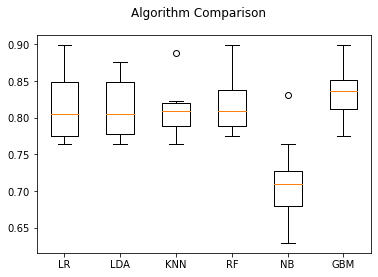

In [168]:
#####################################
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [169]:
#Choosing GBM we now make predictions on the test set
gbm = GradientBoostingClassifier()
gbm.fit(X_scaled, y)
preds = gbm.predict(X_test_scaled)
titanic_test['preds'] = preds
titanic_test.preds.mean()

0.3588516746411483

Additional steps to this project might include more in depth feature engineering, hyperparameter tuning, a holdout validation set to measure generalization performance, or consideration of better performance metrics to optimize.